### **Figure 4: Marmosets show conserved adolescent increases in myelination**

#### **4.1 Setup**

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from stats_helpers import *
from preprocessing_helpers import *
from plotting_helpers import *

#### **4.2 Compute age-related changes in mean T1w/T2w**

Load the filtered dataset generated in 1.2, select developmental subset below 3 years

In [2]:
mean_t12_per_subj_df_filt = pd.read_csv('output/subj_dfs/mean_t12_per_subj_filt.csv', index_col=0)

mean_t12_dev = mean_t12_per_subj_df_filt[mean_t12_per_subj_df_filt['Age'] < 3]

Generate barplot showing age distribution

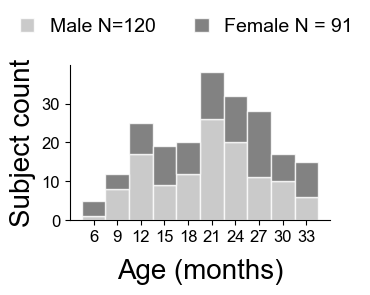

In [ ]:
# Subject dataframe
subject_df = mean_t12_dev[['Age', 'Sex']].copy()

# Assign subjects to 4 month age bins
age_bins = np.arange(0.5,3.1,0.25)
subject_df['Age_bin'] = pd.cut(subject_df['Age'], bins=age_bins, right=False)

# Count males and females in each age bin
male_counts = subject_df[subject_df['Sex'] == 1].groupby('Age_bin', observed=False).size()
female_counts = subject_df[subject_df['Sex'] == 0].groupby('Age_bin', observed=False).size()

# Plot stacked bar chart
ax = plt.figure(figsize=(3.5, 2.5))
plt.bar(male_counts.index.astype(str), male_counts, color=[189/255, 189/255, 189/255, 1], label=f'Male N={male_counts.sum()}', alpha=0.8, width=1, edgecolor='w')
plt.bar(female_counts.index.astype(str), female_counts, bottom=male_counts, color=[99/255,99/255,99/255, 1], label=f'Female N = {female_counts.sum()}', alpha=0.8, width=1, edgecolor='w')

# Add labels and legend
plt.xlabel('Age (months)', fontsize=20, fontfamily='Arial', labelpad=10)
plt.ylabel('Subject count', fontsize=20, fontfamily='Arial')
plt.yticks(fontsize=12, fontfamily='Arial')
plt.xticks(ticks=np.arange(len(age_bins) - 1), labels=[f"{age_bins[i]*12:.0f}" for i in range(len(age_bins) - 1)], rotation=0, fontsize=12, fontfamily='Arial')
legend = ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(0.02, 1.2), frameon=False, ncol=2, columnspacing=2, handlelength=0.75)
for text in legend.get_texts():
    text.set_fontfamily('Arial')
ax=plt.gca()
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Run multiple linear regressions

In [ ]:
# Extract ROIs
rois = mean_t12_dev.columns[4:]

# Run MLR with age and sex as predictors
mlr_results_df = run_mlr(mean_t12_dev, rois, ['Age', 'Sex'])

# Save
mlr_dir = 'output/mlr/'
os.makedirs(mlr_dir, exist_ok=True)

mlr_results_df.to_csv('output/mlr/mean_t12_mlr.csv')

100%|██████████| 230/230 [00:00<00:00, 1207.42it/s]


#### **4.3 Explore biological associations with age-related changes in mean T1w/T2w**

Correlate b_age values with position in cortical hierarchy

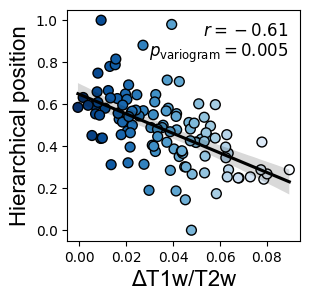

In [ ]:
# Load lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# Load distance matrix
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)

SA_position_correlation(to_plot = mlr_results_df['b_Age'][0:115].values, 
                        dist = dist.values[0:115,0:115],
                        surrogates_filename = 'output/surrogates/T12_b_age_surrogates.csv',
                        n_perm=1000,
                        test_type='two-tailed',
                        x_lab='ΔT1w/T2w', 
                        colour_points_by='x', 
                        cmap='Blues_r', 
                        title_stats=False, 
                        location='top right',
                        save_path=None
)

Correlate with changes in MBP expression

First, extract voxels and mean MBP expression from 6 month image

In [ ]:
# Set paths
MBP_6mo_path = 'data/MBP_6mo_img.nii'
parc_img_path = 'data/sp2_label_512_v1.0.0.nii.gz'

# Extract voxels
MBP_6mo_vox = extract_voxels(
    MBP_6mo_path,
    parc_img_path,
    lut,
    'ROI','Side','bm_code'
)

# Remove outlier values caused by slice artefacts
MBP_6mo_vox = MBP_6mo_vox[MBP_6mo_vox.Value < 0.8]

# Save
MBP_dir = 'output/MBP/'
os.makedirs(MBP_dir, exist_ok=True)
MBP_6mo_vox.to_csv('output/MBP/MBP_6mo_vox.csv')

# Extract mean MBP expression per ROI
MBP_6mo_mean = MBP_6mo_vox.groupby('Label', sort=False).Value.mean()
MBP_6mo_mean.to_csv('output/MBP/MBP_6mo_regional_mean.csv')

100%|██████████| 230/230 [00:08<00:00, 27.87it/s]


Subtract 6 month mean MBP expression from 4 year expression to approximate the difference between mature adult and pre-adolescent myelination

Then correlate this with estimated rates of change in mean T1w/T2w

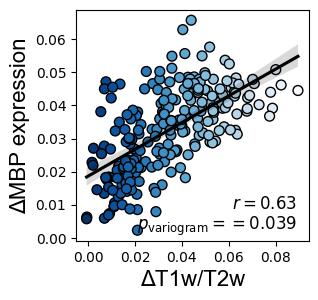

In [ ]:
# ----- Calculate change in mean expression ----- #

MBP_6mo_mean = pd.read_csv('output/MBP/MBP_6mo_regional_mean.csv')
MBP_4Y_mean = pd.read_csv('output/MBP/MBP_4Y_regional_mean.csv')
d_mean_MBP = (MBP_4Y_mean['Value'].values - MBP_6mo_mean['Value'].values) / 3.5 # Divide by age difference to get mean rate of change


# ----- Correlate change in mean T1w/T2w and mean MBP expression ----- #

# Get r and p
r, p = get_brainsmashed_region_correlation_p_val(map_a = mlr_results_df['b_Age'].values,
                                                 map_b = d_mean_MBP,
                                                 regions_ind = None,
                                                 dist = dist.values,
                                                 surrogates_filename = 'output/surrogates/T12_b_age_surrogates.csv', 
                                                 lh=False,
                                                 n_perm=1000, 
                                                 test_type = 'two-tailed')

# Plot correlation
df = pd.DataFrame({
    't12': pd.to_numeric(mlr_results_df['b_Age'].values, errors='coerce'),
    'ISH': pd.to_numeric(d_mean_MBP, errors='coerce')
 })

plt.figure(figsize=(3, 3))
plt.scatter(df["t12"], df["ISH"], c=df["t12"], cmap='Blues_r', edgecolors='black', s=50)
sns.regplot(x="t12", y="ISH", data=df, scatter=False, color='black')

if p < 0.001:
    p_text = '< 0.001'
else:
    p_text = f'= {p:.3f}'

ax = plt.gca(); x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
xpos = x1 + 0.95*(x2-x1); ypos = y1 + 0.2*(y2-y1); ha, va = "right", "top"
ax.text(xpos, ypos, fr'$r = {r:.2f}$' + '\n' + fr'$p_{{\mathrm{{variogram}}}} = {p_text}$', ha=ha, va=va, fontsize=12, fontfamily='Arial')
plt.xlabel('ΔT1w/T2w', fontsize=16, fontfamily='Arial')
plt.ylabel('ΔMBP expression', fontsize=16, fontfamily='Arial')
plt.show()